## Part 1: Data Cleaning and Exploratory Analysis

In the first portion, we will load our dataset with the pairs of quora questions. We will validate the datatypes and check for missing values.

In [1]:
# import necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import os

from pytorch_transformers import *
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

In [2]:
# Get directory for data
path="/Users/student/Desktop/SpringBoardDSCareerTrack/Capstone 3 Datasets/Quora Semantic Pairing"
os.chdir(path)

In [3]:
# Assign data as a dataframe. Obtain the relevant features for analysis
quora_df = pd.read_csv('q_quora.csv')
quora_df = quora_df[['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']]
quora_df.set_index('id', inplace=True)
quora_df.head()

/Users/student/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# Check the datatype and non-null count
quora_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404351 entries, 0 to 404350
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404351 non-null  int64 
 1   qid2          404351 non-null  int64 
 2   question1     404350 non-null  object
 3   question2     404349 non-null  object
 4   is_duplicate  404351 non-null  object
dtypes: int64(2), object(3)
memory usage: 18.5+ MB


We notice two things. First, the non-null counts do not match meaning we must deal with missing values for question1 and question2. Next, the 'is_duplicate' feature should have a Dtype of int since it should be binary, 0 and 1. We address both issues.  

#### Missing Values

In [5]:
# Check the rows where missing values exist
quora_df[quora_df.isna().any(axis=1)]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
105796,209841,209842,How can I develop android app?,NaN,0
201871,398348,398349,How can I create an Android app?,NaN,0
363416,711434,711435,NaN,My Chinese name is Haichao Yu. What English na...,0


In [6]:
# Remove rows with missing value
quora_df.dropna(axis=0, inplace=True)

#### Editing the 'is_duplicate' feature

We should expect the 'is_duplicate' column to be binary between 0 and 1. The dtype however is object so there is likely some string. We will now edit this column.

In [7]:
# Explore the unique values for 'is_duplicate' 
quora_df['is_duplicate'].unique()

array(['0', '1',
       'Do bullets travel faster than the speed of sound when shot from a gun? If not, is it possible? If they do, what gun and how much devastation occurs?',
       'My sister told my crush that I like her without me asking her to do so. What should I do now?',
       ' how would this change the plot for the whole RR story?',
       'What were the greatest achievements of the Persian Empire?',
       'What are the best places to visit in Japan to get a feel for their latest technological advancements?',
       'My boyfriend wants to have sex with me . And I have mixed feelings regarding that. Should I do it or not ?',
       ' mass communication or pharmacy?',
       'What if we are actually moving back in time? Can one differentiate a backward flow of time from forward flow?',
       "I am in love with my classmate, I am gay and he's straight, what should I do?",
       'Does Donald Trump get to deduct his campaign expenses from his taxes?',
       ' 2) share bonanza

There are many text values in the 'is_duplicate' column. We filter our dataset to only the rows where 'is_duplicate' is 0 or 1.

In [8]:
# Obtain the datasets with 0,1 values for is_duplicate, change datatype to int
quora_df = quora_df[(quora_df['is_duplicate'] == str(0)) | (quora_df['is_duplicate'] == str(1))]
print('Unique values of is_duplicate',quora_df['is_duplicate'].unique())
quora_df['is_duplicate'] = quora_df['is_duplicate'].astype(int)

Unique values of is_duplicate ['0' '1']


#### Unique value counts and feature type validation

In [9]:
# Check the unique count for each feature
for col in list(quora_df.columns):
    print('The unique value count for', col, 'is', quora_df[col].value_counts())
    print('\n')

The unique value count for qid1 is 7863      29
2628      19
196396    15
205101    12
26304     11
          ..
737230     1
735183     1
774096     1
253906     1
524288     1
Name: qid1, Length: 398998, dtype: int64


The unique value count for qid2 is 65333     47
147324    39
7863      18
3066      16
173838    16
          ..
317235     1
296761     1
302906     1
300859     1
771862     1
Name: qid2, Length: 397610, dtype: int64


The unique value count for question1 is How do I improve my English speaking?                                                                                                 50
How does the ban on 500 and 1000 rupee notes helps to identify black money and corruption?                                            48
How do I improve my English language?                                                                                                 47
How can changing 500 and 1000 rupee notes end the black money in India?                                    

In [10]:
quora_df.reset_index(drop=False, inplace=True)

## Part 2: Preprocessing and Modeling

In this section, we will preprocess the text (the features 'question1' and 'question2') in our dataset. The preprocessing will be different for each model. In model 1, we will preprocess the text manually and create a tf-idf vector representation for pairs of questions. We wil use cosine similarity to assign the semantic similarity for each pair of questions.

For model 2, we will use the Universal Sentence encoder (USS) module which will create word embeddings for the questions and again use the cosine similarity as the metric. The USE module has its own set of preprocessing steps (under the hood) that essentially summarizes any given sentence to a 512-dimensional sentence embedding. 

For model 3, we will use the package fuzzy wuzzy in which we will use the token_sort_ratio to embed the questions. It then assigns a score between the pair of questions with a range of 0 to 100 where 100 is a "perfect" semantic match. We will divide the score by 100 to make the range 0 to 1 like the cosine similarity scores in model 1 and 2. 

#### Function: Plot Accuracy Based off Threshold

This function will be used at the very end. Using the training data, we plot the duplicate and nonduplicate class accuracy across a range of score (e.g. consine similarity) thresholds. For example, assume the cosine similarity threshold value is 0.5 for the tf-idf model. Then for every pair of questions, if the score is higher than 0.5, we predict the pair as duplicate (1). If less than or equal to 0.5, we assign as nonduplicate (0). 

We then divide total number of a predicted class by the actual amount of that class in the training set. Ex. if the # predicted as 1 based off the threshold is 100 and the actual amount in the class is 160, then we divide 100/160 which gives the accuracy of the prediction for the duplicate class based off the threshold. We do likewise for the nonduplicate class.

We perform this across a range of threshold values and plot the class accuracies vs. the threshold values. The purpose of the plot is to find the threshold or score value that provides the highest possible accuracies for both classes. Since this threshold is based off the training data, we can use the metric on the test data and see the results.

In [11]:
def plot_threshold(score_type, train_data, title):
    thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    dup_pct = []
    nondup_pct=[]
    avg_pct = []
    
    duplicate = train_data[train_data.is_duplicate==1]
    nonduplicate = train_data[train_data.is_duplicate==0]
    
    for thresh in thresholds:
        dup_correct_pct = len(duplicate[duplicate[score_type] > thresh])/len(duplicate)
        dup_pct.append(dup_correct_pct)
        nondup_correct_pct = len(nonduplicate[nonduplicate[score_type] <= thresh])/len(nonduplicate)
        nondup_pct.append(nondup_correct_pct)
        avg_pct.append((dup_correct_pct + nondup_correct_pct) / 2)


    plt.plot(thresholds, dup_pct, label='duplicate')
    plt.plot(thresholds, nondup_pct, label='nonduplicate')
    plt.plot(thresholds, avg_pct, label='avg')
    plt.title('Percent of class identified correctly off thresholds: ' + title)
    plt.legend()
    plt.show()
    
    return None

#### Function: Output confusion matrix

After determining the optimal score threshold from the plot_threshold function, this function will apply the score on the test set and output the classification report with the f-1 score, precision and recall for the duplicate and nonduplicate classes.

In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import sklearn.metrics

def confusion_matrix(test_data, score_metric, thresh, y_test):
    predictions = []
    for i in range(len(test_data)):
        if test_data[score_metric].iloc[i] > thresh:
            predictions.append(1)
        else:
            predictions.append(0)

    y_pred = predictions

    f1 = f1_score(y_test, y_pred, average='weighted')

    # print results
    print('f1-score=%.3f' % (f1))
    print(sklearn.metrics.classification_report(y_test, y_pred))
    
    return None

## Model 1: TF-IDF Vectorizer

In [13]:
# from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim

#### Function will return preprocess question pairs

In [14]:
### This function will take the questions and output a Counter object of the lemmatized 
### text, or the most important words of the question text in its root form.
import string
from unidecode import unidecode

def pre_process(df):

    pairs = []

    for i in range(len(df)):
        # lower case each word
        corpus_1 = df['question1'][i].lower()
        corpus_2 = df['question2'][i].lower()
        
        corpus_1 = " ".join([i for i in word_tokenize(corpus_1) if i.isalpha()])
        corpus_2 = " ".join([i for i in word_tokenize(corpus_2) if i.isalpha()])
        
        stopset = stopwords.words('english') + list(string.punctuation)
        
        if all(i in stopset for i in word_tokenize(corpus_1)):
            corpus_1 = " ".join([i for i in word_tokenize(corpus_1)])
        else:
            corpus_1 = " ".join([i for i in word_tokenize(corpus_1) if i not in stopset])
        
        if all(i in stopset for i in word_tokenize(corpus_2)):
            corpus_2 = " ".join([i for i in word_tokenize(corpus_2)])
        else:
            corpus_2 = " ".join([i for i in word_tokenize(corpus_2) if i not in stopset])
        
        corpus_1 = unidecode(corpus_1)
        corpus_2 = unidecode(corpus_2)
        
        pairs.append([corpus_1, corpus_2])
    
    return pairs

#### Function will calculate cosine similarity between a preprocessed pair of questions

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

#### Preprocess the pair of questions in dataset using pre_process function

In [16]:
preprocessed_pairs = pre_process(quora_df)

#### Turn the preprocessed pairs into tf-idf vectors and compute the cosine similarity between the pair of questions

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

cos_score = []
for i in range(len(preprocessed_pairs)):
    if preprocessed_pairs[i][0] == preprocessed_pairs[i][1]:
        cos_score.append(1)
    else:
        corpus = preprocessed_pairs[i]
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
        tfidf_vectorizer.fit(corpus)
        feature_vectors = tfidf_vectorizer.transform(corpus)
        cos_score.append(get_cosine_similarity(feature_vectors[0], feature_vectors[1]))

In [18]:
## Assign the tf-idf cosine similarity scores into dataframe
quora_df['tfidf_score'] = cos_score
quora_df

,id,qid1,qid2,question1,question2,is_duplicate,tfidf_score
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.875746
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.220201
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.113041
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.084279
...,...,...,...,...,...,...,...
404007,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,0.627904
404008,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1,0.431613
404009,404348,789796,789797,What is one coin?,What's this coin?,0,0.449436
404010,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,0.000000


## Model 2: Universal Sentence Encoder

#### Load universal sentence encoder tools from online url

In [19]:
# Load the url and create instance of it as model
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)

# Function will turn a sentence into word embeddings
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


#### Iterate through pair of questions, embed them, and use cosine_similarity on word embeddings

In [20]:
USE_scores = []

# Iterate through, get word embeddings and calculate cosine similarity
for i in range(len(quora_df)):
    message_embeddings_ = embed([ quora_df['question1'][i], quora_df['question2'][i]])
    score = cosine_similarity(message_embeddings_)[0][1]
    USE_scores.append(score)

In [21]:
# Assign the USE cosine similarity scores to dataframe
quora_df['USE_score'] = USE_scores
quora_df

,id,qid1,qid2,question1,question2,is_duplicate,tfidf_score,USE_score
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.875746,0.936438
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.220201,0.684390
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.113041,0.609381
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0.124987
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.084279,0.335715
...,...,...,...,...,...,...,...,...
404007,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,0.627904,0.757957
404008,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1,0.431613,0.904780
404009,404348,789796,789797,What is one coin?,What's this coin?,0,0.449436,0.794427
404010,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,0.000000,0.131100


## Model 3: Fuzzywuzzy

In [22]:
# pip install fuzzywuzzy

In [23]:
# Import fuzzyquzzy package
from fuzzywuzzy import fuzz

/Users/student/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### Iterate through pair of questions, embed them with method token_sort_ratio, and use Levenshtein Distance on word embeddings

In [24]:
fuzz_scores = []
for i in range(len(quora_df)):
    score = fuzz.token_sort_ratio(quora_df['question1'].iloc[i], quora_df['question2'].iloc[i])/100
    fuzz_scores.append(score)

In [36]:
# Assign scores to dataframe
quora_df['fuzz_score'] = fuzz_scores
quora_df

,id,qid1,qid2,question1,question2,is_duplicate,tfidf_score,USE_score,fuzz_score
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.875746,0.936438,0.93
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.220201,0.684390,0.63
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.113041,0.609381,0.63
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0.124987,0.24
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.084279,0.335715,0.47
...,...,...,...,...,...,...,...,...,...
404007,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,0.627904,0.757957,0.88
404008,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1,0.431613,0.904780,0.69
404009,404348,789796,789797,What is one coin?,What's this coin?,0,0.449436,0.794427,0.75
404010,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,0.000000,0.131100,0.35


### Split into training and test set

In [26]:
# Splitting the training and testing data
from sklearn.model_selection import train_test_split

X = quora_df
y = quora_df['is_duplicate']   # this is our predictor variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=26)

### Model 1 Performance

#### Plot for tf-idf model. Choose the optimal cosine similarity score threshold for highest class prediction accuracies (where the duplicate and nonduplicate line plot intersects) from the training data.

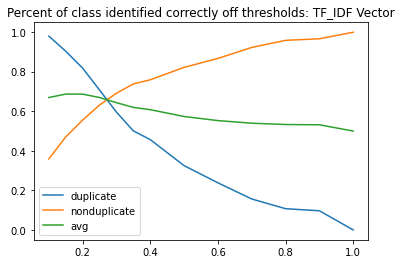

In [27]:
plot_threshold('tfidf_score', X_train, 'TF_IDF Vector')

#### Looks like the best score occurs around a cosine similarity score of 0.3. Obtain the prediction results on the test set.

In [28]:
confusion_matrix(X_test, 'tfidf_score', 0.3, y_test)

f1-score=0.661
              precision    recall  f1-score   support

           0       0.75      0.69      0.72     50967
           1       0.53      0.60      0.56     29836

    accuracy                           0.66     80803
   macro avg       0.64      0.64      0.64     80803
weighted avg       0.67      0.66      0.66     80803



### Model 2 Performance

#### Plot for USE model. Choose the optimal cosine similarity score threshold for highest class prediction accuracies (where the duplicate and nonduplicate line plot intersects) from the training data.

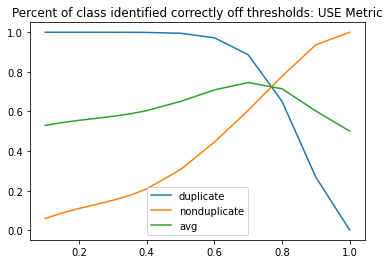

In [32]:
plot_threshold('USE_score', X_train, 'USE Metric')

#### Looks like the best score occurs around a cosine similarity score of 0.78. Obtain the prediction results on the test set.

In [33]:
confusion_matrix(X_test, 'USE_score', 0.78, y_test)

f1-score=0.737
              precision    recall  f1-score   support

           0       0.82      0.74      0.78     50967
           1       0.62      0.71      0.66     29836

    accuracy                           0.73     80803
   macro avg       0.72      0.73      0.72     80803
weighted avg       0.74      0.73      0.74     80803



### Model 3 Performance

#### Plot for fuzzy wuzzy model. Choose the optimal Levenshtein distance score threshold for highest class prediction accuracies (where the duplicate and nonduplicate line plot intersects) from the training data.

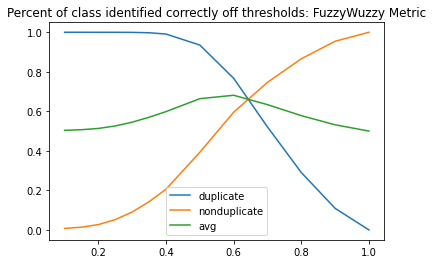

In [34]:
plot_threshold('fuzz_score', X_train, 'FuzzyWuzzy Metric')

#### Looks like the best score occurs around a cosine similarity score of 0.64. Obtain the prediction results on the test set.

In [35]:
confusion_matrix(X_test, 'fuzz_score', 0.64, y_test)

f1-score=0.673
              precision    recall  f1-score   support

           0       0.78      0.66      0.72     50967
           1       0.54      0.68      0.60     29836

    accuracy                           0.67     80803
   macro avg       0.66      0.67      0.66     80803
weighted avg       0.69      0.67      0.67     80803



## Part 3: Concluding Thoughts

#### Best Model: Model 2 Universal Sentence Encoder

While model 1 (tf-idf) and model 3 (fuzzy wuzzy) perform well and has a shorter preprocessing time, the Universal Sentence Encoder model performs the best in terms of the f1-score metric as well as precision and recall values across both classes. A deployment model here then work in the following way. 

Given a new pair of questions, we use the Universal Sentence Encoding word embedding process which will convert each sentence into a 512 dimension numerical vector that captures only the most informative features and discard noise. Then we take the cosine similarity between the embeddings and if the score is greater than 0.78, we conclude they are duplicates and have the same semantic meaning. Otherwise, the sentences are not duplicates.